In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)

In [ ]:
two_pipe_fps = os.listdir('two-pipes')
three_pipe_fps = os.listdir('three-pipes')
four_pipe_fps = os.listdir('four-pipes')
eight_pipe_fps = os.listdir('eight-pipes')

microbench = os.listdir('final-microbenchmarks')

In [ ]:
with open('final-microbenchmarks/rank0_1_None_None_2022-12-10 19:21:17.436822.json') as f:
    t = json.load(f)
t['train_params']

{'rank': 0,
 'world_size': 1,
 'epochs': 2,
 'batch_size': 250,
 'learning_rate': 0.003,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'scheduler_step_size': 50,
 'gamma': 0.9}

In [ ]:
def calc_total_times(fps, source_dir):
    epoch_total_times, allreduce_total_times, randomk_total_times, backward_total_times, forward_total_times = [], [], [], [], []
    compression_types, compression_metrics, batch_sizes, n_microbatches = [], [], [], []
    for i, fp in enumerate(fps):
        compression_types.append(fp.split('_')[2])
        compression_metrics.append(fp.split('_')[3])
        with open(os.path.join(source_dir, fp)) as f:
            data = json.load(f)
        
        epoch_total_times.append(sum([data[f"trainloop_epoch{i}_rank0"]['total_time'] for i in range(data['train_params']['epochs'])]))
        
        if compression_types[i] == 'randomk':
            compression_types[i] += f" (k = {compression_metrics[i]})"
            allreduce_total_times.append(data['randomk.all_reduce']['total_time'])
        elif compression_types[i] == 'powersgd':
            allreduce_total_times.append(data['powersgd.uncompressed.all_reduce']['total_time'] + data['powersgd.Ps.all_reduce']['total_time'] + data['powersgd.Qs.all_reduce']['total_time'])
        elif (source_dir == './') or (source_dir == 'final-microbenchmarks'):
            pass
        else:
            allreduce_total_times.append(data['pytorch.all_reduce']['total_time'])
        
        backward_total_times.append(sum([data[f"backward_epoch{i}_rank0"]['total_time'] for i in range(data['train_params']['epochs'])]))
        forward_total_times.append(sum([data[f"forward_epoch{i}_rank0"]['total_time'] for i in range(data['train_params']['epochs'])]))
        batch_sizes.append(data['train_params']['batch_size'])
        n_microbatches.append(int(fp.split('_')[1]))
    if (source_dir == './') or (source_dir == 'final-microbenchmarks'):
        return pd.DataFrame({'microbatches': n_microbatches, 'batch_size': batch_sizes, 'compression_type': compression_types, 'epoch_total_time': epoch_total_times, 'backward_total_time': backward_total_times, 'forward_total_time': forward_total_times}) 
    return pd.DataFrame({'compression_type': compression_types, 'epoch_total_time': epoch_total_times, 'allreduce_total_time': allreduce_total_times, 'backward_total_time': backward_total_times, 'forward_total_time': forward_total_times}) 

In [ ]:
def calc_avg_times(fps, source_dir):
    epoch_avg_times, allreduce_avg_times, randomk_avg_times, backward_avg_times, forward_avg_times = [], [], [], [], []
    compression_types, compression_metrics, batch_sizes, n_microbatches = [], [], [], []
    for i, fp in enumerate(fps):
        compression_types.append(fp.split('_')[2])
        compression_metrics.append(fp.split('_')[3])
        with open(os.path.join(source_dir, fp)) as f:
            data = json.load(f)
            
        epoch_avg_times.append(np.mean([data[f"trainloop_epoch{i}_rank0"]['average_duration'] for i in range(data['train_params']['epochs'])]))
        
        if compression_types[i] == 'randomk':
            compression_types[i] += f" (k = {compression_metrics[i]})"
            allreduce_avg_times.append(data['randomk.all_reduce']['average_duration'])
        elif compression_types[i] == 'powersgd':
            allreduce_avg_times.append(data['powersgd.uncompressed.all_reduce']['average_duration'] + data['powersgd.Ps.all_reduce']['average_duration'] + data['powersgd.Qs.all_reduce']['average_duration'])
        elif (source_dir == './') or (source_dir == 'final-microbenchmarks'):
            pass
        else:
            allreduce_avg_times.append(data['pytorch.all_reduce']['average_duration'])
        
        backward_avg_times.append(np.mean([data[f"backward_epoch{i}_rank0"]['average_duration'] for i in range(data['train_params']['epochs'])]))
        forward_avg_times.append(np.mean([data[f"forward_epoch{i}_rank0"]['average_duration'] for i in range(data['train_params']['epochs'])]))
        batch_sizes.append(data['train_params']['batch_size'])
        n_microbatches.append(int(fp.split('_')[1]))
    if (source_dir == './') or (source_dir == 'final-microbenchmarks'):
        return pd.DataFrame({'microbatches': n_microbatches, 'batch_size': batch_sizes, 'compression_type': compression_types, 'epoch_avg_time': epoch_avg_times, 'backward_avg_time': backward_avg_times, 'forward_avg_time': forward_avg_times} )
    return pd.DataFrame({'compression_type': compression_types, 'epoch_avg_time': epoch_avg_times, 'allreduce_avg_time': allreduce_avg_times, 'backward_avg_time': backward_avg_times, 'forward_avg_time': forward_avg_times} )

In [ ]:
calc_avg_times(microbench, 'final-microbenchmarks')

,microbatches,batch_size,compression_type,epoch_avg_time,backward_avg_time,forward_avg_time
0,8,1000,None,22.790143,0.248656,0.100779
1,4,750,None,24.293202,0.187954,0.075250
2,1,750,None,29.889568,0.250714,0.077531
3,32,500,None,76.019446,0.520247,0.126759
4,4,1000,None,22.038952,0.235226,0.100653
5,4,250,None,35.035540,0.093018,0.028735
6,8,500,None,29.998555,0.169166,0.054431
7,4,500,None,26.704863,0.146239,0.050510
8,1,500,None,32.873417,0.180145,0.052653
9,8,250,None,44.378849,0.134415,0.040089


In [ ]:
microbenchmarks = calc_total_times(microbench, 'final-microbenchmarks').merge(calc_avg_times(microbench, 'final-microbenchmarks'), on = ['compression_type','microbatches', 'batch_size'])

one_pipe_results = calc_total_times(['rank0_8_None_None_2022-12-09 22:59:42.196488.json'], './').merge(calc_avg_times(['rank0_8_None_None_2022-12-09 22:59:42.196488.json'], './'), on = 'compression_type')
one_pipe_results['n_pipelines'] = 1

two_pipes_results = calc_total_times(two_pipe_fps, 'two-pipes').merge(calc_avg_times(two_pipe_fps, 'two-pipes'), on = 'compression_type')
two_pipes_results['n_pipelines'] = 2

three_pipes_results = calc_total_times(three_pipe_fps, 'three-pipes').merge(calc_avg_times(three_pipe_fps, 'three-pipes'), on = 'compression_type')
three_pipes_results['n_pipelines'] = 3

four_pipes_results = calc_total_times(four_pipe_fps, 'four-pipes').merge(calc_avg_times(four_pipe_fps, 'four-pipes'), on = 'compression_type')
four_pipes_results['n_pipelines'] = 4

eight_pipes_results = calc_total_times(eight_pipe_fps, 'eight-pipes').merge(calc_avg_times(eight_pipe_fps, 'eight-pipes'), on = 'compression_type')
eight_pipes_results['n_pipelines'] = 8

In [ ]:
result_df = pd.concat([one_pipe_results, two_pipes_results, three_pipes_results, four_pipes_results, eight_pipes_results]).fillna(0)
#result_df['epoch_throughput'] = 50_000 / result_df['epoch_avg_time'] 
result_df['epoch_throughput'] = 50_000*10 / (result_df['allreduce_total_time'] + result_df['forward_total_time'] + result_df['backward_total_time'])
result_df['allreduce_prop_total_time'] = result_df['allreduce_total_time'] / (result_df['allreduce_total_time'] + result_df['forward_total_time'] + result_df['backward_total_time'])
result_df['backward_prop_total_time'] = result_df['backward_total_time'] /  (result_df['allreduce_total_time'] + result_df['forward_total_time'] + result_df['backward_total_time'])
result_df['forward_prop_total_time'] = result_df['forward_total_time'] /  (result_df['allreduce_total_time'] + result_df['forward_total_time'] + result_df['backward_total_time'])

t_1 = np.sum(result_df.loc[result_df.n_pipelines==1,'epoch_throughput'].values)
#result_df = result_df[result_df.n_pipelines!=1].copy()

result_df.sort_values(['n_pipelines', 'compression_type'])

,microbatches_x,batch_size_x,compression_type,epoch_total_time,backward_total_time,forward_total_time,microbatches_y,batch_size_y,epoch_avg_time,backward_avg_time,forward_avg_time,n_pipelines,allreduce_total_time,allreduce_avg_time,epoch_throughput,allreduce_prop_total_time,backward_prop_total_time,forward_prop_total_time
0,8.0,1000.0,None,209.130230,127.234677,29.431591,8.0,1000.0,20.913023,0.254469,0.058863,1,0.000000,0.000000,3191.497486,0.000000,0.812138,0.187862
0,0.0,0.0,None,264.560359,208.569294,19.286355,0.0,0.0,26.456036,0.417139,0.038573,2,121.556118,0.024340,1430.976419,0.347888,0.596915,0.055197
2,0.0,0.0,powersgd,178.223404,115.210084,19.052167,0.0,0.0,17.822340,0.230420,0.038104,2,6.902426,0.001534,3541.962563,0.048896,0.816140,0.134964
1,0.0,0.0,randomk (k = 0.3),224.029982,169.321885,19.288580,0.0,0.0,22.402998,0.338644,0.038577,2,40.058834,0.008021,2186.563756,0.175182,0.740466,0.084351
4,0.0,0.0,randomk (k = 0.5),277.635168,222.221156,19.376192,0.0,0.0,27.763517,0.444442,0.038752,2,64.342538,0.012884,1634.307988,0.210311,0.726356,0.063333
3,0.0,0.0,randomk (k = 0.8),375.831784,319.051941,19.546862,0.0,0.0,37.583178,0.638104,0.039094,2,119.738114,0.023976,1090.900561,0.261245,0.696108,0.042647
4,0.0,0.0,None,306.729801,252.705771,19.248034,0.0,0.0,30.672980,0.495502,0.037741,3,174.646848,0.034285,1119.568445,0.391058,0.565843,0.043099
1,0.0,0.0,powersgd,167.786858,105.545055,18.675836,0.0,0.0,16.778686,0.206951,0.036619,3,5.217867,0.001134,3862.830611,0.040311,0.815405,0.144283
3,0.0,0.0,randomk (k = 0.3),222.233277,169.572295,19.405674,0.0,0.0,22.223328,0.332495,0.038050,3,46.718500,0.009171,2121.372471,0.198215,0.719452,0.082333
0,0.0,0.0,randomk (k = 0.5),274.082536,221.312604,19.326902,0.0,0.0,27.408254,0.433946,0.037896,3,72.843511,0.014300,1594.982733,0.232368,0.705980,0.061652


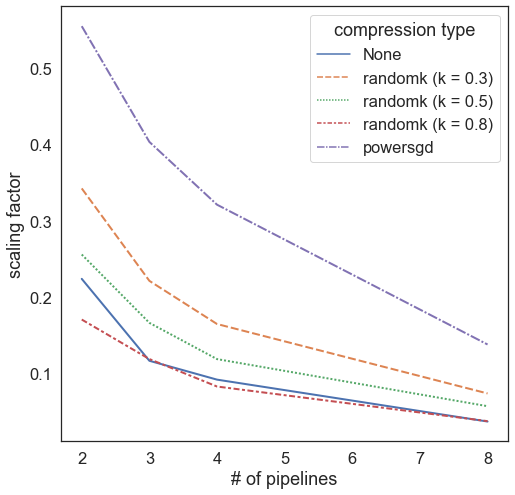

In [ ]:
comp_types = ['None', 'randomk (k = 0.3)', 'randomk (k = 0.5)', 'randomk (k = 0.8)', 'powersgd']
types, scaling_factors, n_pipelines = [], [], []
for comp_type in comp_types:
    for i in [2,3,4,8]:
        types.append(comp_type)
        n_pipelines.append(i)
        scaling_factors.append(result_df.loc[(result_df.n_pipelines==i) & (result_df.compression_type==comp_type),'epoch_throughput'].values[0] / (t_1*i))
scaling_df = pd.DataFrame({'compression_type': types, 'n_pipelines': n_pipelines, 'scaling_factor': scaling_factors}) 

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=scaling_df, x='n_pipelines', y='scaling_factor', hue='compression_type', style='compression_type', linewidth=2, ax=ax)
ax.set_xlabel('# of pipelines')
ax.set_ylabel('scaling factor')
#ax.set_title('Scaling factors of no compression and compression')
ax.legend(title='compression type')
plt.savefig('scaling_factor.png')
plt.show()

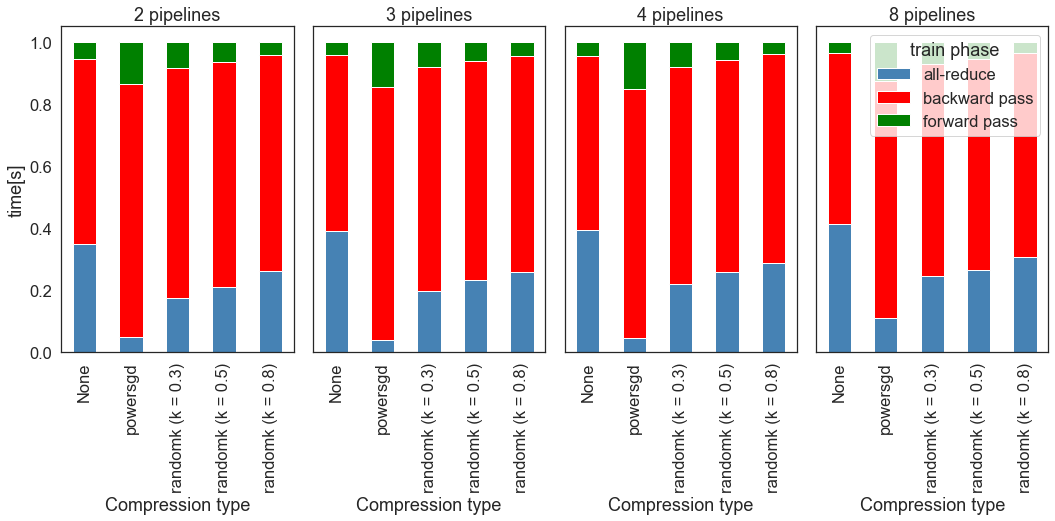

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (15,8))
n_pipes = [2,3,4,8]
for i, ax in enumerate(axs):
    
    result_df.loc[result_df.n_pipelines==n_pipes[i] ,['compression_type', 'allreduce_prop_total_time', 'backward_prop_total_time', 'forward_prop_total_time']].set_index('compression_type').sort_index().plot(kind='bar', stacked=True, color=['steelblue', 'red', 'green'], ax=ax)
    ax.set_xlabel('Compression type')
    ax.get_legend().remove()
    if i > 0:
        ax.set_yticks([])
    ax.set_title(f'{n_pipes[i]} pipelines')

axs[0].set_ylabel('time[s]')
axs[3].legend(loc='upper right', title= 'train phase', labels= ['all-reduce', 'backward pass', 'forward pass'])
#fig.suptitle('Proportion of total train time spent in each phase (backward pass, forward pass, all reduce)')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig('train_time_breakdown.png',bbox_inches='tight')
plt.show()

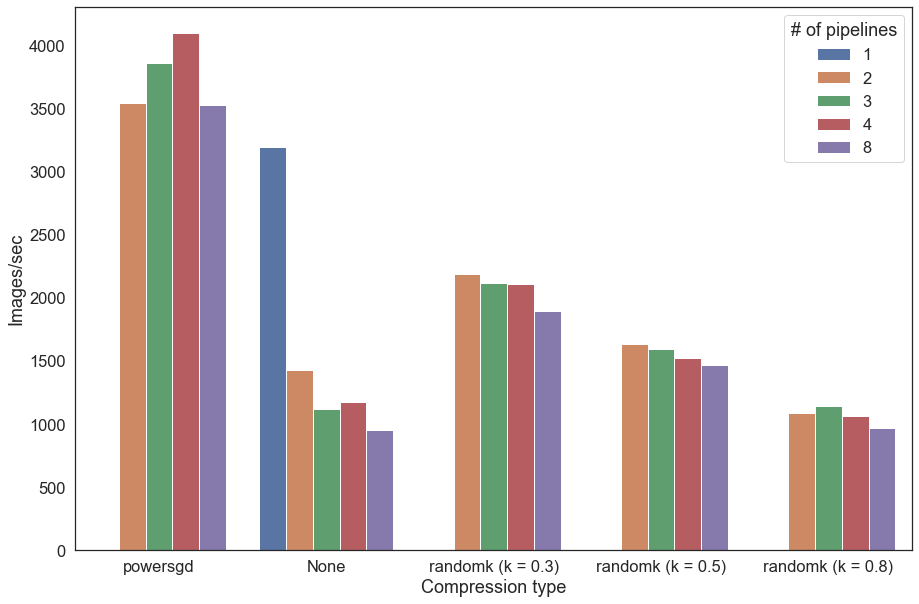

In [ ]:
fig, ax = plt.subplots(1, figsize = (15,10))

sns.barplot(x='compression_type', y='epoch_throughput', hue='n_pipelines', data = result_df.sort_values('epoch_throughput', ascending=False), ax=ax)
ax.legend(loc='upper right', title= '# of pipelines')
ax.set_xlabel('Compression type')
ax.set_ylabel('Images/sec')
#plt.title('Throughput')
plt.savefig('throughput.png')
plt.show()

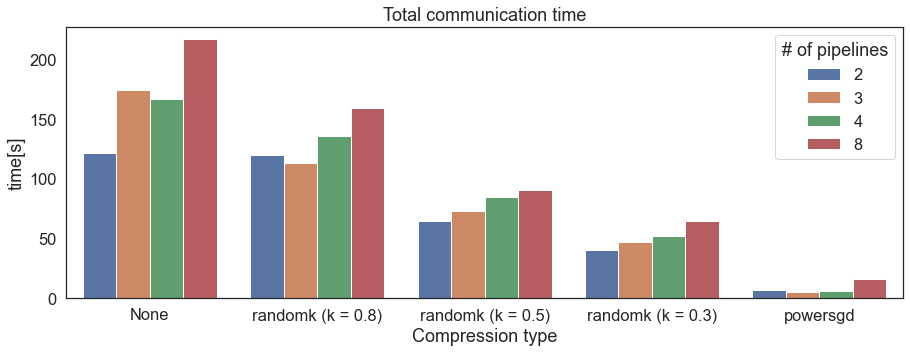

In [ ]:
fig, ax = plt.subplots(1, figsize = (15,5))

sns.barplot(x='compression_type', y='allreduce_total_time', hue='n_pipelines', data = result_df[result_df.n_pipelines != 1].sort_values('allreduce_total_time', ascending=False),  ax=ax)
ax.legend(loc='upper right', title= '# of pipelines')
ax.set_xlabel('Compression type')
ax.set_ylabel('time[s]')
plt.title('Total communication time')
plt.savefig('total_comm_time.png')
plt.show()

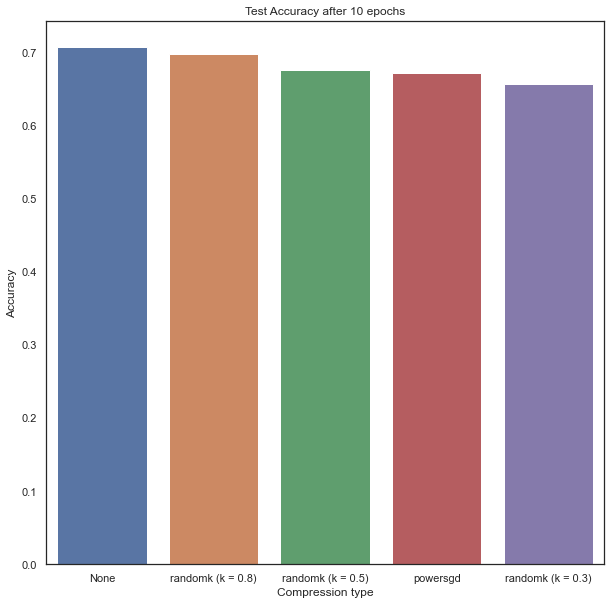

In [ ]:
val_accuracy = [0.7075, 0.656, 0.676, 0.6975, 0.671]
comp_type = ['None', 'randomk (k = 0.3)', 'randomk (k = 0.5)', 'randomk (k = 0.8)', 'powersgd']
model_perf = pd.DataFrame({'Accuracy': val_accuracy, 'Compression type': comp_type})

fig, ax = plt.subplots(1, figsize = (10,10))
sns.barplot(x='Compression type', y='Accuracy', data=model_perf.sort_values('Accuracy', ascending=False), ax=ax)
plt.title('Test Accuracy after 10 epochs')
plt.savefig('accuracy.png')
plt.show()

In [ ]:
microbenchmarks['epoch_throughput'] = 50_000*2 / (microbenchmarks['forward_total_time'] + microbenchmarks['backward_total_time'])
microbenchmarks

,microbatches,batch_size,compression_type,epoch_total_time,backward_total_time,forward_total_time,epoch_avg_time,backward_avg_time,forward_avg_time,epoch_throughput
0,8,1000,None,45.580287,24.865623,10.077898,22.790143,0.248656,0.100779,2861.760799
1,4,750,None,48.586405,25.185868,10.083470,24.293202,0.187954,0.075250,2835.323995
2,1,750,None,59.779136,33.595675,10.389122,29.889568,0.250714,0.077531,2273.512798
3,32,500,None,152.038892,104.049363,25.351852,76.019446,0.520247,0.126759,772.790273
4,4,1000,None,44.077904,23.522550,10.065276,22.038952,0.235226,0.100653,2977.269203
5,4,250,None,70.071080,37.207218,11.493874,35.035540,0.093018,0.028735,2053.342038
6,8,500,None,59.997110,33.833199,10.886300,29.998555,0.169166,0.054431,2236.161027
7,4,500,None,53.409725,29.247736,10.101973,26.704863,0.146239,0.050510,2541.314821
8,1,500,None,65.746835,36.028906,10.530563,32.873417,0.180145,0.052653,2147.790830
9,8,250,None,88.757698,53.765835,16.035496,44.378849,0.134415,0.040089,1432.637447
